# Post training with hybrid loss evaluation against a sanity check model
The objective of this notebook is to demonstrate that one can optimise a network via training with a hybrid loss. 
The training losses (available on wandb at this link: ) demonstrate minimal performance improvement at asymptotic convergence than a sanity-check alternative. 
The objective here is to evaluate the quality of explanations which have been generated by these models. 

## Helper functions
The following functions contain the bulk of the specific helper functions necessary to evaluate the performance and explanation of VGG16 vs VGG19. 
Generic helper functions have been moved to the utils folder for use in other notebooks. 

In [4]:

import sys
sys.path.append('..')
import torch
import torchvision.models as models
import numpy as np
import pandas as pd  
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from baselines.trainVggBaselineForCIFAR10 import vgg
from experiments import WrapperNet, perform_lrp_plain, evaluate_performance, evaluate_explanations
from internal_utils import get_vgg16, get_vgg19, get_pretrained_model, get_CIFAR10_dataloader, preprocess_images, condense_to_heatmap, blur_image_batch, add_random_noise_batch, get_CIFAR_10_dataloader_without_normalization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRUNCATE = 25
print(f"WARNING: TRUNCATING THE DATASET TO {TRUNCATE} --- THIS WILL ALSO BE TRUNCATED IN THE FUNCTIONS INCLUDED IN THE experiments/run_evaluation.py FILE")
print(f"TO RUN OVER THE ENTIRE DATASET, UNCOMMENT THE RELEVANT LINES IN THE FUNCTIONS (SEARCH FOR THE STRING 'TRUNCATE')")


def plot_comparative_figure(df, method_0, method_1, data_type="Train"):
    """
    Plot a comparative figure of the results between the two models.
    """
    figs_per_row = ["distance_noise_small", "distance_noise_large", "distance_blur_small", "distance_blur_large"]

    # Create a single row figure with two boxplots per column
    fig, axs = plt.subplots(1, len(figs_per_row), figsize=(20, 5), sharey=True)

    for j, fig_type in enumerate(figs_per_row):
        # Filter data for method_0
        if "small" in fig_type:
            df_method_0 = df[df[f"{method_0}_{fig_type}_class_change"] == False]
        else:
            df_method_0 = df[df[f"{method_0}_{fig_type}_class_change"] == True]
        
        # Filter data for method_1
        if "small" in fig_type:
            df_method_1 = df[df[f"{method_1}_{fig_type}_class_change"] == False]
        else:
            df_method_1 = df[df[f"{method_1}_{fig_type}_class_change"] == True]

        # Combine the data for boxplot using a hue for methods
        combined_df = pd.DataFrame({
            'Value': pd.concat([df_method_0[f"{method_0}_{fig_type}"], df_method_1[f"{method_1}_{fig_type}"]]),
            'Method': [method_0] * len(df_method_0) + [method_1] * len(df_method_1)
        })

        # Create boxplot
        sns.boxplot(x='Method', y='Value', hue= 'Method', data=combined_df, ax=axs[j])
        axs[j].set_title(f"{fig_type}".replace("_", " "))
    fig.suptitle(f"Comparative Analysis of {method_0} and {method_1} on {data_type} Data", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    
def visualise_panel_image(image, label, model, kernel_size_min=1, kernel_size_max=7, noise_level_min=0.05, noise_level_max=0.3, method=perform_lrp_plain, fig_label="LRP"):
    """Visualise the panel of images for the model."""
    # Assume the image tensor is already in batch format, if not, unsqueeze it
    if image.dim() == 3:
        image = image.unsqueeze(0)
    
    original_image = image
    # treated images
    blurred_small = blur_image_batch(image, kernel_size_min)
    blurred_large = blur_image_batch(image, kernel_size_max)
    noisy_small = add_random_noise_batch(image, noise_level_min)
    noisy_large = add_random_noise_batch(image, noise_level_max)
    
    # model outputs
    original_heatmap = condense_to_heatmap(method(preprocess_images(image), label, model, return_output=False)).detach()
    blurred_small_heatmap = condense_to_heatmap(method(preprocess_images(blurred_small), label, model, return_output=False)).detach()
    blurred_large_heatmap = condense_to_heatmap(method(preprocess_images(blurred_large),label,  model, return_output=False)).detach()
    noisy_small_heatmap = condense_to_heatmap( method(preprocess_images(noisy_small), label, model, return_output=False)).detach()
    noisy_large_heatmap = condense_to_heatmap(method(preprocess_images(noisy_large), label, model, return_output=False)).detach()
    
    # Display images
    fig, ax = plt.subplots(2, 5, figsize=(15, 5))
    ax[0][0].imshow(original_image.squeeze().permute(1, 2, 0).cpu().numpy())
    ax[0][0].set_title('Original Image')
    ax[0][1].imshow(blurred_small.squeeze().permute(1, 2, 0).cpu().numpy())
    ax[0][1].set_title('Small Blurred Image')
    ax[0][2].imshow(blurred_large.squeeze().permute(1, 2, 0).cpu().numpy())
    ax[0][2].set_title('Large Blurred Image')
    ax[0][3].imshow(noisy_small.squeeze().detach().permute(1, 2, 0).cpu().numpy())  # Example visualization
    ax[0][3].set_title('Small Noisy Image')
    ax[0][4].imshow(noisy_large.squeeze().detach().permute(1, 2, 0).cpu().numpy())  # Example visualization
    ax[0][4].set_title('Large Noisy Image')
    
    ax[1][0].imshow(original_heatmap.squeeze(0), cmap='seismic')
    ax[1][0].set_title('Original Heatmap')
    ax[1][1].imshow(blurred_small_heatmap.squeeze(0), cmap='seismic')
    ax[1][1].set_title('Small Blurred Heatmap')
    ax[1][2].imshow(blurred_large_heatmap.squeeze(0), cmap='seismic')
    ax[1][2].set_title('Large Blurred Heatmap')
    ax[1][3].imshow(noisy_small_heatmap.squeeze(0), cmap ='seismic')  # Example visualization
    ax[1][3].set_title('Small Noisy Heatmap')
    ax[1][4].imshow(noisy_large_heatmap.squeeze(0), cmap ='seismic')  # Example visualization
    ax[1][4].set_title('Large Noisy Heatmap')
    fig.suptitle(f"{fig_label}")
    
    for i in ax:
        for j in i:
            j.axis('off')
    plt.show()

TO RUN OVER THE ENTIRE DATASET, UNCOMMENT THE RELEVANT LINES IN THE FUNCTIONS (SEARCH FOR THE STRING 'TRUNCATE')


## Pre-training evaluation
Here, we evaluate the performance of the models on the test and train data, and then evaluate the quality of explanations over the same datasets. 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.050988235..1.0607715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7619654..1.7472228].


Label type: torch.Size([])
Image Shape: torch.Size([3, 32, 32])


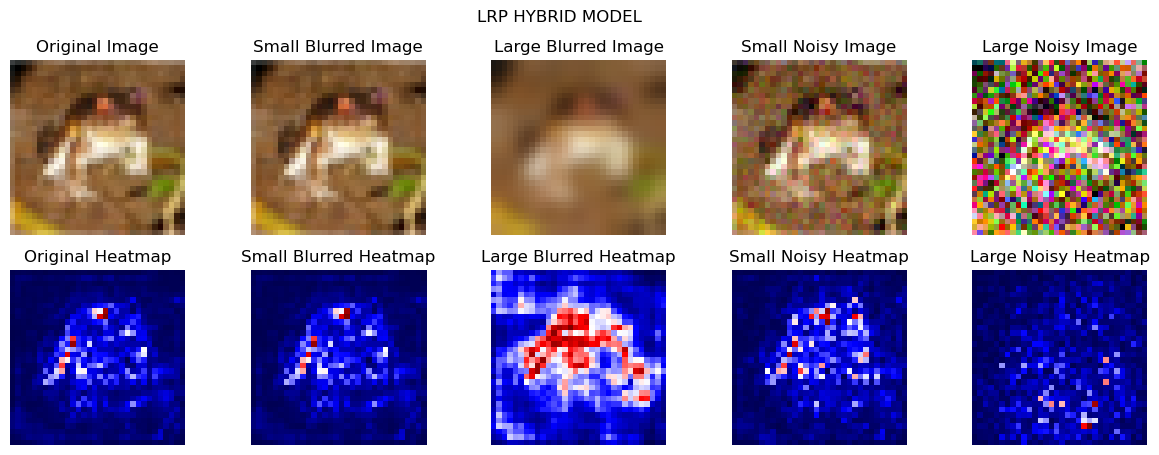

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06940605..1.1252366].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71454793..1.6392931].


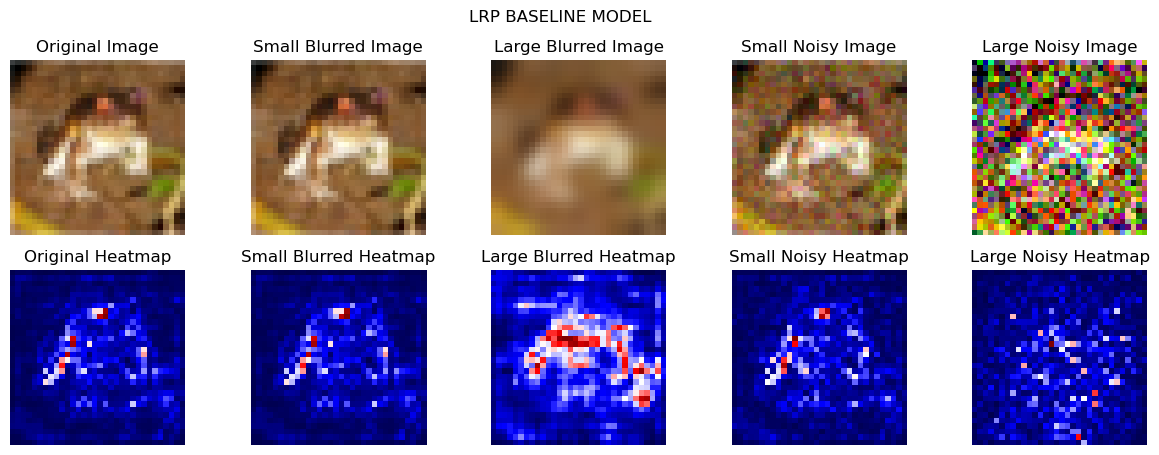

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13351138..1.0750866].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6770733..1.7922964].


Label type: torch.Size([])
Image Shape: torch.Size([3, 32, 32])


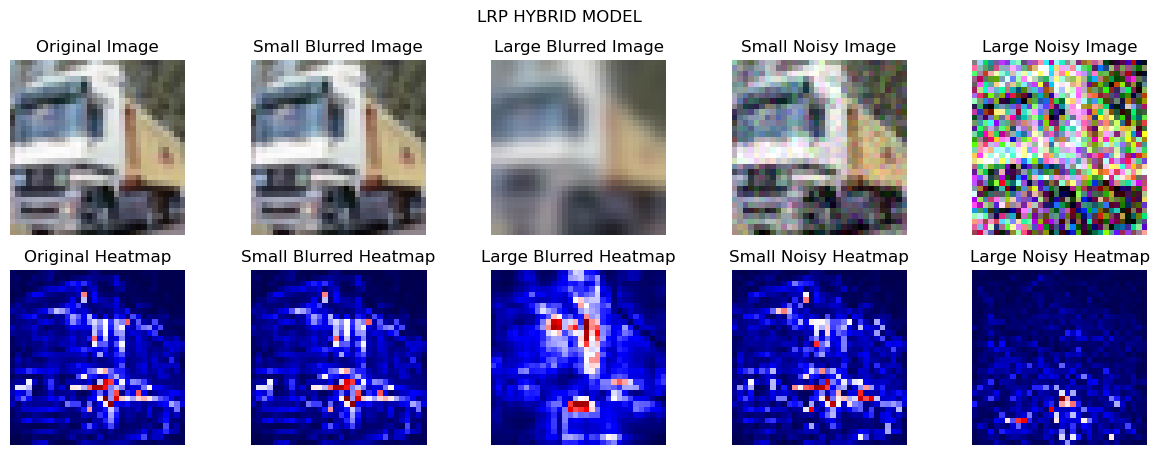

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.046075266..1.0911214].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7418903..1.9081541].


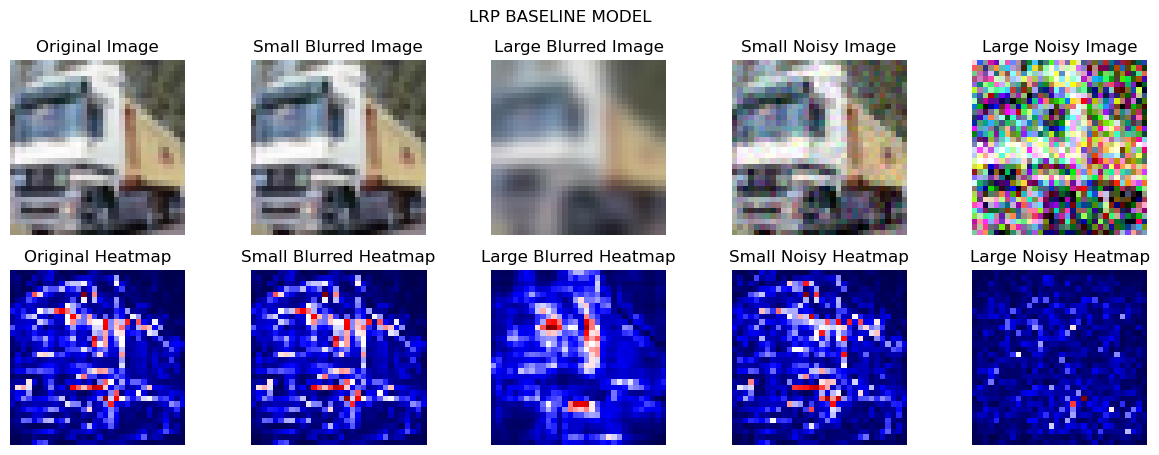

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.033012338..1.1186129].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6578963..1.895785].


Label type: torch.Size([])
Image Shape: torch.Size([3, 32, 32])


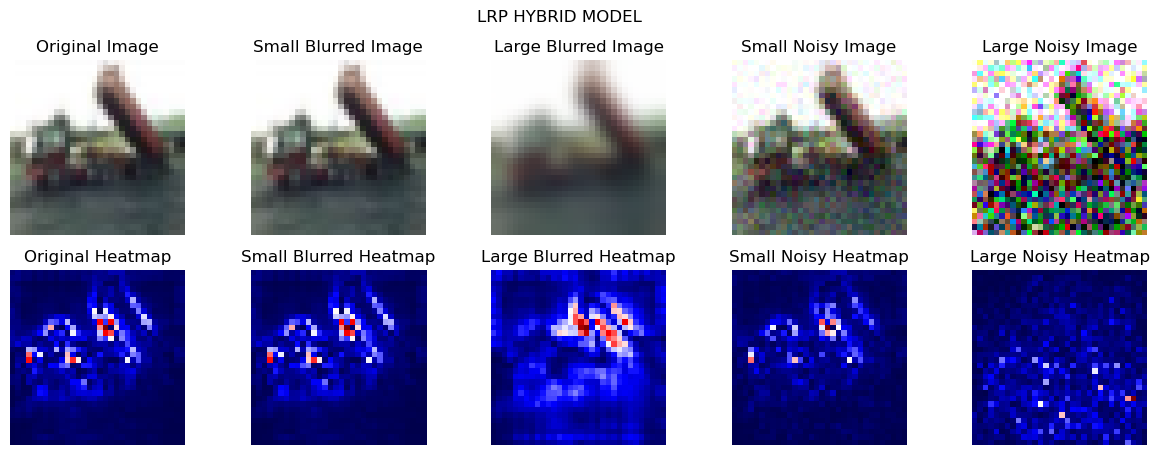

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07173629..1.2244234].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.68642783..1.9538696].


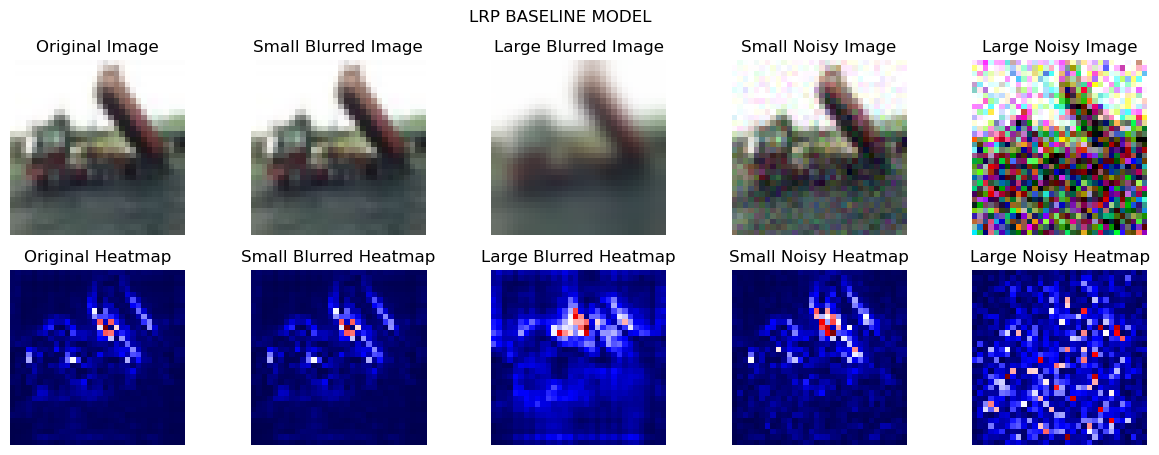

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054610163..0.97231346].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.77916265..1.5596751].


Label type: torch.Size([])
Image Shape: torch.Size([3, 32, 32])


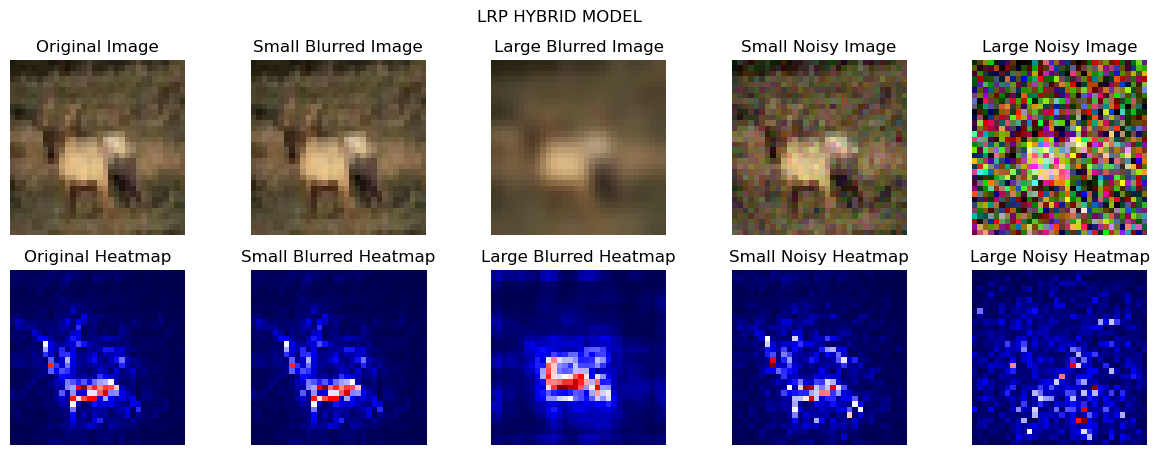

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.019247659..0.96542865].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75978243..1.5173453].


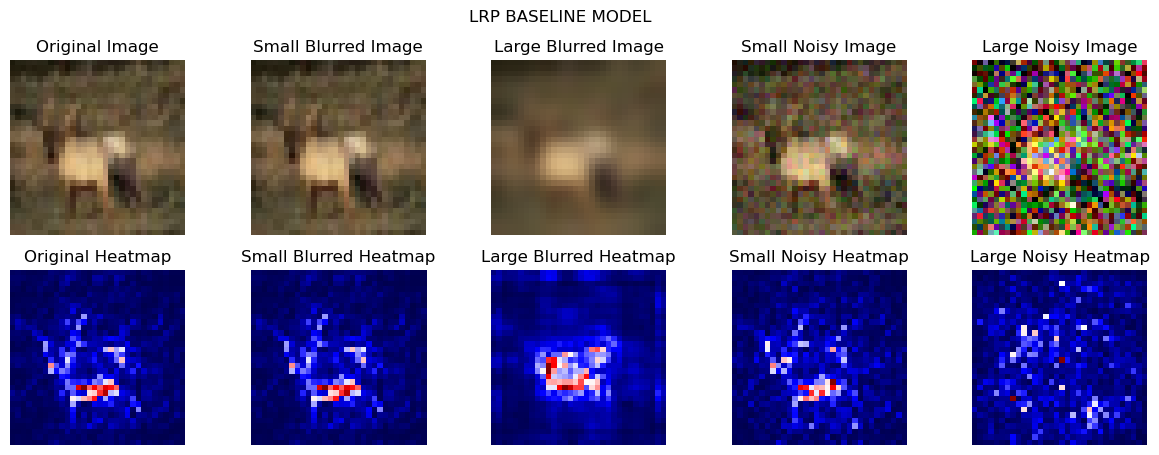

In [5]:

# Load the models
hybrid_model = get_pretrained_model("/Users/charleshiggins/Personal/CharlesPhD/CodeRepo/xai_intervention/RL-LRP/model_files/checkpoint_299_2024-08-06_02-23-55_default.tar", vgg.vgg11)
baseline_model  = get_pretrained_model("/Users/charleshiggins/Personal/CharlesPhD/CodeRepo/xai_intervention/RL-LRP/model_files/checkpoint_299_2024-08-06_11-16-09_sanity_check.tar", vgg.vgg11)

# Load test and train data to run evaluation over
train_data, test_data = get_CIFAR_10_dataloader_without_normalization(train=True, batch_size=8, num_workers=4, pin_memory=True), get_CIFAR_10_dataloader_without_normalization(train=False, batch_size=8, num_workers=4, pin_memory=True)

# Generate some sample images of the data
NUM_IMAGES = 4
images, labels = next(iter(train_data))
image_batch, label_batch = images[:4], labels[:4]
for image, label in zip(image_batch, label_batch):
    print(f"Label type: {label.shape}")
    print(f"Image Shape: {image.shape}")
    visualise_panel_image(image, label.unsqueeze(0), WrapperNet(hybrid_model, hybrid_loss=True), method=perform_lrp_plain, fig_label="LRP HYBRID MODEL")
    visualise_panel_image(image, label.unsqueeze(0), WrapperNet(baseline_model, hybrid_loss=True), method=perform_lrp_plain, fig_label="LRP BASELINE MODEL")


In [ ]:

# Analyse performance over train and test set on the two models
hybrid_results_train, hybrid_results_test = evaluate_performance(hybrid_model, train_data, test_data, convert_to_imagenet_labels=False)
baseline_results_train, baseline_results_test  = evaluate_performance(baseline_model, train_data, test_data, convert_to_imagenet_labels=False)

# visualise results from the initial dataframes
hybrid_results_train['model'] = 'HYBRID'
hybrid_results_test['model'] = 'HYBRID'
baseline_results_train['model'] = 'BASELINE'
baseline_results_test['model'] = 'BASELINE'

# Concatenate dataframes
combined_df_train = pd.concat([hybrid_results_train, baseline_results_train])
combined_df_test = pd.concat([hybrid_results_test, baseline_results_test])

# Melt the dataframe to long format for seaborn
melted_df_train = combined_df_train.melt(id_vars=['model'], var_name='metric', value_name='value')
melted_df_test = combined_df_test.melt(id_vars=['model'], var_name='metric', value_name='value')

# Create the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='metric', y='value', hue='model', data=melted_df_train)
plt.title('Model Performance Comparison (Train Set)')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.legend(title='Model (Train)')
plt.show()

# Create the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='metric', y='value', hue='model', data=melted_df_test)
plt.title('Model Performance Comparison (Test Set)')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.legend(title='Model (Test)')
plt.show()

# To evaluate the explanations, we need to pass in a list of "methods"
# each method is a tuple of the form (name, method, model)
# name is a string which identifies the method -- i.e. "VGG16"
# method is a function which generates a heatmap on a certain model --- i.e. perform_lrp_plain
# model is the model which the method is applied to --- it needs to be in the heatmap form (i.e.)
methods = [
        ("HYBRID", perform_lrp_plain, WrapperNet(hybrid_model, hybrid_loss=True)),
        ("BASELINE", perform_lrp_plain, WrapperNet(baseline_model, hybrid_loss=True))
    ]
# now evaluate explanations
print("WARNING: EVAULUATING EXPLANATIONS IS TOO COMPUTATIONALLY INTENSE FOR A NOTEBOOK. WE SUGGEST RUNNING THIS IN A SCRIPT, AND LOADING THE RESULTS FROM .csv FILES FOR ANALYSIS.")
# df_train, df_test = evaluate_explanations(train_data, test_data, methods, save_results = True, convert_to_imagenet_labels=False)


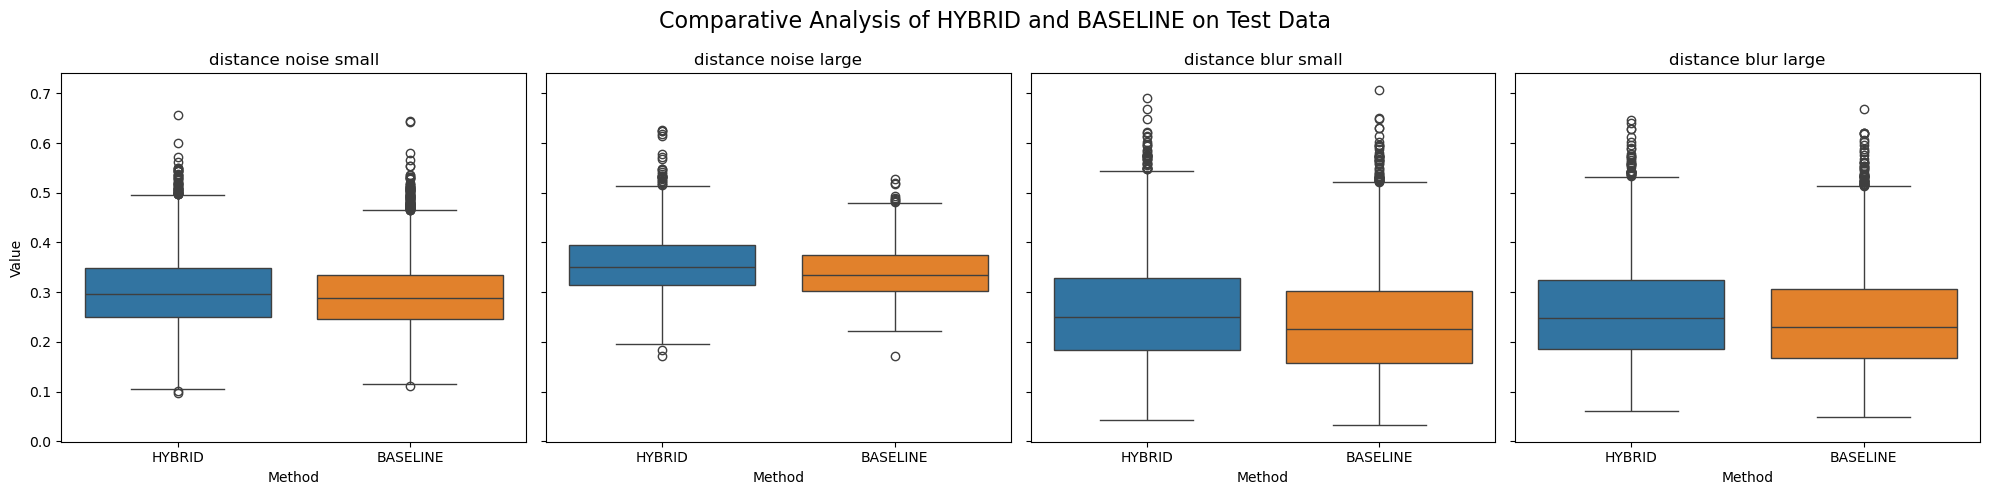

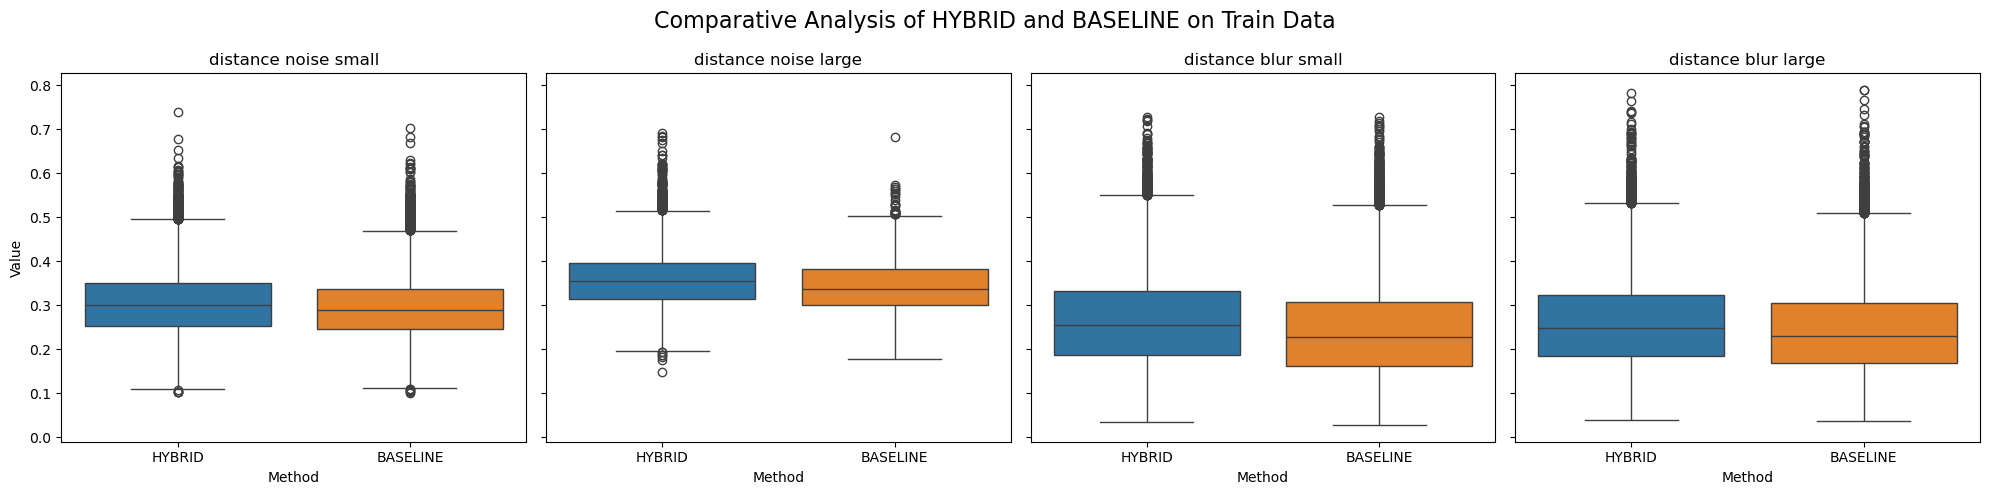

In [6]:
ROOT_DIR = "/Users/charleshiggins/Personal/CharlesPhD/CodeRepo/xai_intervention/RL-LRP"
df_train = pd.read_csv(f"{ROOT_DIR}/explanation_evaluation_CIFAR10__train_results.csv")
df_test = pd.read_csv(f"{ROOT_DIR}/explanation_evaluation_CIFAR10__test_results.csv")
plot_comparative_figure(df_test, "HYBRID", "BASELINE", "Test")
plot_comparative_figure(df_train, "HYBRID", "BASELINE", "Train")

In [ ]:
df_train.to_csv("hybrid-baseline-CIFAR10_train_results.csv")
df_test.to_csv("hybrid-baseline-CIFAR10_test_results.csv")
